In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
import keras.callbacks
import warnings
import joblib
#warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [4]:
df.isna().sum()

id                            0
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64

In [5]:
df.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [6]:
df.nunique()

id                      3116945
class                         2
cap-diameter               3913
cap-shape                    74
cap-surface                  83
cap-color                    78
does-bruise-or-bleed         26
gill-attachment              78
gill-spacing                 48
gill-color                   63
stem-height                2749
stem-width                 5836
stem-root                    38
stem-surface                 60
stem-color                   59
veil-type                    22
veil-color                   24
has-ring                     23
ring-type                    40
spore-print-color            32
habitat                      52
season                        4
dtype: int64

In [7]:
temp_df = df.copy()

In [8]:
df = df.drop(['id', 'cap-surface', 'gill-attachment', 'gill-spacing', 'stem-root', 'stem-surface', 'veil-type', 
             'veil-color', 'ring-type', 'spore-print-color'], axis=1)

In [9]:
df['cap-diameter'] = df['cap-diameter'].fillna(df['cap-diameter'].mean())
df = df.fillna('missing')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-color             object 
 4   does-bruise-or-bleed  object 
 5   gill-color            object 
 6   stem-height           float64
 7   stem-width            float64
 8   stem-color            object 
 9   has-ring              object 
 10  habitat               object 
 11  season                object 
dtypes: float64(3), object(9)
memory usage: 285.4+ MB


In [21]:
unique_values = df['cap-shape'].unique()
print(unique_values)

['f' 'x' 'p' 'b' 'o' 'c' 's' 'other']


In [28]:
threshold = 0.01

def replace_less_frequent(column, threshold):
    value_counts = column.value_counts(normalize=True)
    less_frequent_values = value_counts[value_counts < threshold].index
    return column.replace(less_frequent_values, "other")

In [23]:
X = df.drop(['class'], axis=1)

In [26]:
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

In [31]:
for col in categorical_cols:
    df[col] = replace_less_frequent(df[col], threshold)

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [32]:
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df[categorical_cols] = ordinal_encoder.fit_transform(df[categorical_cols].astype(str))

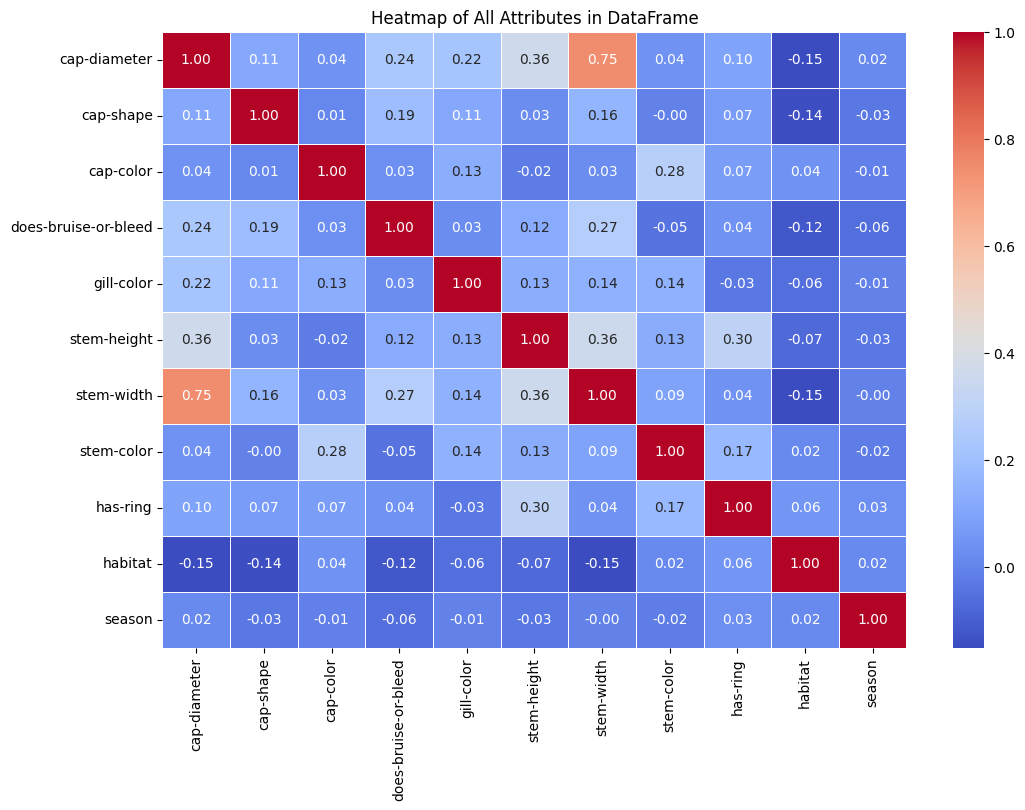

In [37]:
corr_df = df.drop(['class'], axis=1)
correlation_matrix = corr_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap of All Attributes in DataFrame")
plt.show()

In [40]:
X = df.drop(['class'], axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [45]:
model = CatBoostClassifier(learning_rate=0.1, random_seed=42, verbose=0)
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'iterations': [100, 200]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose=0)

best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters: {'depth': 8, 'iterations': 200, 'learning_rate': 0.15}
Best CV Accuracy: 0.9769


In [47]:
joblib_file = "big_model.joblib"
joblib.dump(best_model, joblib_file)

['big_model.joblib']

In [49]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077964 entries, 0 to 2077963
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), int64(1), object(17)
memory usage: 332.9+ MB


In [51]:
for col in categorical_cols:
    test[col] = replace_less_frequent(test[col], threshold)

In [53]:
test[numerical_cols] = scaler.transform(test[numerical_cols])

In [54]:
def replace_unseen_with_other(column, known_values):
    return column.apply(lambda x: x if x in known_values else "other")

# Replace unseen values in the test set before encoding
for col in categorical_cols:
    known_values = ordinal_encoder.categories_[categorical_cols.index(col)]
    test[col] = replace_unseen_with_other(test[col].astype(str), known_values)

In [55]:
test[categorical_cols] = ordinal_encoder.transform(test[categorical_cols].astype(str))

In [58]:
test = test.drop(['id', 'cap-surface', 'gill-attachment', 'gill-spacing', 'stem-root', 'stem-surface', 'veil-type', 
             'veil-color', 'ring-type', 'spore-print-color'], axis=1)

In [59]:
test

,cap-diameter,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-height,stem-width,stem-color,has-ring,habitat,season
0,0.500255,7.0,5.0,2.0,11.0,1.771149,0.736981,8.0,2.0,0.0,0.0
1,0.126698,3.0,6.0,0.0,12.0,-1.881035,-0.049878,3.0,0.0,0.0,0.0
2,-0.925272,0.0,5.0,0.0,5.0,-0.062351,-0.989909,3.0,0.0,0.0,1.0
3,-0.609681,7.0,5.0,0.0,5.0,-0.506836,-0.326576,8.0,2.0,0.0,2.0
4,-0.030024,7.0,12.0,0.0,12.0,0.141371,0.314523,9.0,2.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
2077959,-1.165722,7.0,11.0,0.0,11.0,-1.362470,-1.211020,0.0,0.0,0.0,2.0
2077960,-0.684821,7.0,11.0,0.0,11.0,-1.355062,-0.466160,8.0,0.0,1.0,0.0
2077961,-0.124486,7.0,1.0,0.0,11.0,-0.069759,-0.174639,9.0,2.0,0.0,0.0
2077962,-0.274768,0.0,5.0,0.0,3.0,-0.129024,-0.950381,1.0,0.0,0.0,0.0


In [60]:
y_pred = best_model.predict(test)

In [62]:
sub['class'] = y_pred

In [63]:
sub.to_csv('submission.csv', index=False)